In [6]:
import os,sys
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
import matplotlib.pyplot as plt
sys.path.append('../LIB/')
from env import ENV
from sklearn.preprocessing import normalize
from tqdm import tqdm
import pickle
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import gc

print_to_file = False 
test_run = False 

train = pd.read_pickle(ENV.lightgbm_train_764.value)
print('train shape is: {}'.format(train.shape))
test = pd.read_pickle(ENV.lightgbm_test_764.value)
print('test shape is: {}'.format(test.shape))
fe_id = 'comb_764'

train shape is: (307511, 764)
test shape is: (48744, 763)


In [12]:
train.dtypes.value_counts()

float64    540
float32    192
int64       19
uint8       11
dtype: int64

In [7]:
train['SK_ID_CURR'] = train['SK_ID_CURR'].astype(int)
test['SK_ID_CURR'] = test['SK_ID_CURR'].astype(int)
targets = train.TARGET.values

In [8]:
train_id = train['SK_ID_CURR']
test_id = test['SK_ID_CURR']

# LOAD FIRST features

In [4]:
extra_feature_wei = pd.read_pickle('../../data/add_features/install_preapp_hand_fe.pkl')

# sure_add_features_wei = ['Wei_Remaning_CNT_Payment_TOTAL',
#  'Wei_TOTAl_NEEDPAY_INCOME_RATIO',
#  'Wei_Remaining_AMT_Payment_TOTAL',
#  'Wei_Normed_CNT_LATE_PAYMENT_LAST','SK_ID_CURR']
# extra_feature_wei = extra_feature_wei[sure_add_features_wei]


print(extra_feature_wei.shape)
print(extra_feature_wei.columns)

train_merge = train.merge(extra_feature_wei, how='left', left_on='SK_ID_CURR',right_on='SK_ID_CURR')
print(train_merge.shape)

test_merge = test.merge(extra_feature_wei, how='left', left_on='SK_ID_CURR',right_on='SK_ID_CURR')
print(test_merge.shape)

(339587, 19)
Index(['SK_ID_CURR', 'Wei_Normed_CNT_LATE_PAYMENT_MEAN',
       'Wei_Normed_CNT_LATE_PAYMENT_MAX', 'Wei_Normed_CNT_LESS_PAYMENT_MEAN',
       'Wei_Normed_CNT_LESS_PAYMENT_MAX', 'Wei_Install_Payment_Rate_MEAN',
       'Wei_Install_Payment_Rate_MIN', 'Wei_CNT_installment_per_version_STD',
       'Wei_Remaining_AMT_Payment_TOTAL', 'Wei_CNT_NOT_TERMINATION',
       'Wei_Normed_CNT_LATE_PAYMENT_LAST', 'Wei_Normed_CNT_LESS_PAYMENT_LAST',
       'Wei_Install_Payment_Rate_LAST', 'Wei_CNT_installment_per_version_LAST',
       'Wei_Remaining_AMT_Payment_LAST', 'Wei_Remaning_CNT_Payment_TOTAL',
       'Wei_IF_TERMINATION_LAST', 'Wei_Remaing_Payment_Ratio_CURR',
       'Wei_TOTAl_NEEDPAY_INCOME_RATIO'],
      dtype='object')
(307511, 782)
(48744, 781)


In [5]:
extra_feature_shiyi = pd.read_pickle('../../data/add_features/shiyi/shiyifeature1.pkl')



train_merge = train_merge.merge(extra_feature_shiyi, how='left', left_on='SK_ID_CURR',right_on='SK_ID_CURR')
print(train_merge.shape)

test_merge = test_merge.merge(extra_feature_shiyi, how='left', left_on='SK_ID_CURR',right_on='SK_ID_CURR')
print(test_merge.shape)


(307511, 790)
(48744, 789)


In [6]:
print(extra_feature_shiyi.columns)

Index(['SK_ID_CURR', 'APR_posloan_riskscore_mean', 'cnt_cash_regular_pay',
       'cnt_cash_earlypayoff', 'APR_cashloan_riskscore_mean',
       'cnt_cash_30days_late', 'cnt_cons_30days_late', 'cnt_cons_regular_pay',
       'cnt_cons_earlypayoff'],
      dtype='object')


In [4]:
drop_list = ['NAME_EDUCATION_TYPE_CODE_GENDER_AMT_CREDIT_mean_abs_diff',
                'inst_DAYS_INSTALMENT_std']



train = train_merge.drop(drop_list,axis=1).copy()
print(train.shape)

test = test_merge.drop(drop_list,axis=1).copy()
print(test.shape)

NameError: name 'train_merge' is not defined

# main func

In [10]:
from sklearn.model_selection import train_test_split

def get_time(timezone='America/New_York', time_format='%Y-%m-%d %H:%M:%S'):
    from datetime import datetime
    from dateutil import tz

    # METHOD 1: Hardcode zones:
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz(timezone)

    utc = datetime.utcnow()

    # Tell the datetime object that it's in UTC time zone since 
    # datetime objects are 'naive' by default
    utc = utc.replace(tzinfo=from_zone)

    # Convert time zone
    est = utc.astimezone(to_zone)

    return est.strftime(time_format)

import sys, time
class Logger(object):
    def __init__(self, logtofile=True, logfilename='log'):
        self.terminal = sys.stdout
        self.logfile = "{}_{}.log".format(logfilename, int(time.time()))
        self.logtofile = logtofile

    def write(self, message):
        #         self.terminal.write(message)
        if self.logtofile:
            self.log = open(self.logfile, "a")
            self.log.write('[' + get_time() + '] ' + message)
            self.log.close()

    def flush(self):
        # this flush method is needed for python 3 compatibility.
        # this handles the flush command by doing nothing.
        # you might want to specify some extra behavior here.
        pass


def divert_printout_to_file():
    sys.stdout = Logger(logfilename='logfile')

if print_to_file:
    divert_printout_to_file()  # note: comment this to use pdb

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, train_df, test_df, holdout, num_folds, submission_file_name, fe_img_name, stratified = False, debug= False, colsample=0.67, max_depth=8, num_leaves=31, min_child_samples=20, subsample=0.7, reg_lambda=0.3, lr=0.04, seed=1001, verbose=100, rounds=None):
    print(train_df.shape, test_df.shape, holdout.shape)
    print('MEAN: train({}) vs holdout({}): '.format(len(train_df), len(holdout)), train_df['TARGET'].mean(), holdout['TARGET'].mean())
    # Divide in training/validation and test data
    if df is not None:
        train_df = df[df['TARGET'].notnull()]
        test_df = df[df['TARGET'].isnull()]
        print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
        del df
        gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
        
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    holdout_final_preds = np.zeros(holdout.shape[0])
    feature_importance_df = pd.DataFrame()
    feature_importance_gain_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_scores = []
    holdout_scores = []
    scores = []
    diff_val_holdout = []
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#         print('valid index : ',list(valid_idx)[:5])
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
#         print('MEAN: train({}) vs valid({}): '.format(len(train_y), len(valid_y)), np.mean(train_y), np.mean(valid_y))

        clf = LGBMClassifier(
            nthread=18,
            n_estimators=30000,
            learning_rate=lr,
            num_leaves=num_leaves,
            colsample_bytree=colsample, # 0.67
            subsample=subsample,
            subsample_freq=0, ## disable subsampling
            max_depth=max_depth,
            reg_alpha=0.65,
            reg_lambda=reg_lambda,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            min_child_samples=min_child_samples,
            silent=-1,
            verbose=-1, )
        if rounds is not None:
            clf.n_estimators = rounds
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose=verbose)
            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
            sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
            holdout_preds = clf.predict_proba(holdout[feats])[:, 1] 
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose=verbose, early_stopping_rounds= 200)
            oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
            sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
            holdout_preds = clf.predict_proba(holdout[feats], num_iteration=clf.best_iteration_)[:, 1] 
            
        holdout_final_preds += holdout_preds / folds.n_splits
        score = roc_auc_score(valid_y, oof_preds[valid_idx])
        train_score = clf.best_score_['training']['auc']
        holdout_score = roc_auc_score(holdout['TARGET'], holdout_preds)
        diff = abs(score - holdout_score)
        best_rounds = rounds if rounds is not None else clf.best_iteration_
        print('Fold %2d [%5d] AUC : ho: %.6f / te: %.6f / tr: %.6f (diff: %.6f)' % (n_fold + 1, best_rounds, holdout_score, score,  train_score, diff))
        scores.append(score)
        train_scores.append(train_score)
        holdout_scores.append(holdout_score)
        diff_val_holdout.append(diff)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        fold_importance_gain_df = pd.DataFrame()
        fold_importance_gain_df["feature"] = feats
        fold_importance_gain_df["importance"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance_gain_df["fold"] = n_fold + 1
        feature_importance_gain_df = pd.concat([feature_importance_gain_df, fold_importance_gain_df], axis=0)
        
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
    holdout_roc = roc_auc_score(holdout['TARGET'], holdout_final_preds)
    holdout_mean = np.mean(holdout_scores)
    full_te_mean = np.mean(scores)
    full_tr_mean = np.mean(train_scores)
#     print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    print('Full HO score %.6f' % holdout_roc)
    print('FULL HO mean {:.6f}, std {:.6f}'.format(holdout_mean, np.std(holdout_scores)))
    print('FULL TE mean {:.6f}, std {:.6f}'.format(full_te_mean, np.std(scores)))
    print('FULL TR mean {:.6f}, std {:.6f}'.format(full_tr_mean, np.std(train_scores)))
    print('FULL DIFF mean {:.6f}, std {:.6f}'.format(np.mean(diff_val_holdout), np.std(diff_val_holdout)))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
#     if not print_to_file:
#         display_importances(feature_importance_df, fe_img_name)
    feature_importance_df = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    feature_importance_gain_df = feature_importance_gain_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    return feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds 

# Display/plot feature importance
def display_importances(feature_importance_df_, fe_img_name):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(fe_img_name+'.png')


def convert_and_save_imp_df(fe_imp_df, dumpfilename):
    fe_imp_df_mean = fe_imp_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    pickle.dump(fe_imp_df_mean, open(dumpfilename,'wb'))

In [9]:
def runlgb(train, test, holdout, seed=20):
    colsamples = [0.07]#[0.1,0.15,0.2]#[0.03,0.04,0.05,0.06,0.07,0.08]
    seeds = [seed]#[300,4000,50000,600000,7000000,80000000,523445,31275479] # 20
    depth = [5]
    leaves = [16]
    min_child_sam = [20]#, 800]
    subsamples = [1]#0.8, 0.7, 0.6, 0.5, 0.4] # was 1
    reg_lambdas = [0.5]
    # lrs = lrs.tolist()
    lrs2 = [0.05]
    nfolds = 6
    rounds = [1000] #[1000]#, 1300, 1600, 1900, 2200, 2500]
    for seed in seeds:
        for colsample in colsamples:
            for d in depth:
                for l in leaves:
                    for mcs in min_child_sam:
                        for subsample in subsamples:
                            for reg_lambda in reg_lambdas:
                                for lr in lrs2:
                                    for r in rounds:
                                        filename = 'fe_936_col{}_lr{}_n{}'.format(len(train.columns), lr, nfolds)
                                        print('#############################################')
                                        print(colsample, seed, d, l, mcs, subsample, reg_lambda, lr, 'nfolds:', nfolds)
                                        print('#############################################')
                                        numfeats = len(train.columns)
                                        with timer("Run LightGBM with kfold"):
                                            return kfold_lightgbm(None, train, test, holdout, nfolds, filename+'.csv', filename, colsample=colsample, verbose=None, max_depth=d, num_leaves=l, min_child_samples=mcs, subsample=subsample, reg_lambda=reg_lambda, lr=lr, seed=seed, stratified=True, rounds=r,debug=True)
    #                                         

In [10]:
train_df, holdout = train_test_split(train, test_size=1/10000, random_state=42)
print('MEAN: train({}) vs holdout({}): '.format(len(train_df), len(holdout)), train_df['TARGET'].mean(), holdout['TARGET'].mean())
print(train_df.shape, test.shape, holdout.shape)

MEAN: train(307480) vs holdout(31):  0.08072394952517237 0.12903225806451613
(307480, 787) (48744, 786) (31, 787)


# Experiment

In [12]:
avai_fe_all = [ 'Wei_Normed_CNT_LATE_PAYMENT_MEAN',
       'Wei_Normed_CNT_LATE_PAYMENT_MAX', 'Wei_Normed_CNT_LESS_PAYMENT_MEAN',
       'Wei_Normed_CNT_LESS_PAYMENT_MAX', 'Wei_Install_Payment_Rate_MEAN',
       'Wei_Install_Payment_Rate_MIN', 'Wei_CNT_installment_per_version_STD',
       'Wei_Remaining_AMT_Payment_TOTAL', 'Wei_CNT_NOT_TERMINATION',
       'Wei_Normed_CNT_LATE_PAYMENT_LAST', 'Wei_Normed_CNT_LESS_PAYMENT_LAST',
       'Wei_Install_Payment_Rate_LAST', 'Wei_CNT_installment_per_version_LAST',
       'Wei_Remaining_AMT_Payment_LAST', 'Wei_Remaning_CNT_Payment_TOTAL',
       'Wei_IF_TERMINATION_LAST', 'Wei_Remaing_Payment_Ratio_CURR',
       'Wei_TOTAl_NEEDPAY_INCOME_RATIO',
               'APR_posloan_riskscore_mean', 'cnt_cash_regular_pay',
       'cnt_cash_earlypayoff', 'APR_cashloan_riskscore_mean',
       'cnt_cash_30days_late', 'cnt_cons_30days_late', 'cnt_cons_regular_pay',
       'cnt_cons_earlypayoff'
              ]

# avai_fe_all = [ 'APR_posloan_riskscore_mean', 'cnt_cash_regular_pay',
#        'cnt_cash_earlypayoff', 'APR_cashloan_riskscore_mean',
#        'cnt_cash_30days_late', 'cnt_cons_30days_late', 'cnt_cons_regular_pay',
#        'cnt_cons_earlypayoff']

# avai_fe_all = [  'Wei_CNT_installment_per_version_LAST',
#         'Wei_Remaing_Payment_Ratio_CURR',
#        'Wei_TOTAl_NEEDPAY_INCOME_RATIO']

sure_add_feature = []


seed = np.random.randint(200) + 1
seed =20

avai_fe_cur = list(set(avai_fe_all) - set(sure_add_feature))
drop_cur = list(set(avai_fe_cur)  )
train_df_cur = train_df.drop(drop_cur,axis=1)
print('\n')
print('adding... {}'.format('no add'))
print(train_df_cur.shape)
test_cur = test.drop(drop_cur,axis=1)
holdout_cur = holdout.drop(drop_cur,axis=1)
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_df_cur, test_cur, holdout_cur, seed)
best_cv = full_te_mean



round = 1
for col in avai_fe_all:
    avai_fe_cur = list(set(avai_fe_all) - set(sure_add_feature))
    col_list = []
    full_te_mean_list = []

    # current loop
    for each_col in avai_fe_cur:
        drop_cur = list(set(avai_fe_cur) - set([each_col]) )
        train_df_cur = train_df.drop(drop_cur,axis=1)
        print('\n')
        print('adding... {}'.format(sure_add_feature+[each_col]))
        print(train_df_cur.shape)
        test_cur = test.drop(drop_cur,axis=1)
        holdout_cur = holdout.drop(drop_cur,axis=1)
        feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_df_cur, test_cur, holdout_cur,seed)
        full_te_mean_list.append(full_te_mean)
        col_list.append(each_col)
        
    seri = pd.Series(index=col_list,data=full_te_mean_list)
    filtered_seri = seri[seri>best_cv]
    print('current round is: {}'.format(round))
    print('current filtered series is: {}'.format(filtered_seri))
    if len(filtered_seri) == 0:
        print('no availabe, break!')
        print('current best score is: {}'.format(best_cv))
        break
    else:
        filtered_seri = filtered_seri.sort_values(ascending=False)
        best_cv = filtered_seri.values[0]
        sure_add_feature.append(filtered_seri.index.values[0])
        print('current sure added feature is: {}'.format(sure_add_feature))
        print('current highest cs is: {}'.format(best_cv))
        
        seed = np.random.randint(200) + 1
        seed =20
        # next round, the seed is changed.
        drop_cur = list(set(avai_fe_all) - set(sure_add_feature))
        train_df_cur = train_df.drop(drop_cur,axis=1)
        print('\n')
        print('adding... {}'.format(sure_add_feature))
        print(train_df_cur.shape)
        test_cur = test.drop(drop_cur,axis=1)
        holdout_cur = holdout.drop(drop_cur,axis=1)
        feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_df_cur, test_cur, holdout_cur, seed)
        best_cv = full_te_mean
        print('after swiching seed to: {}. The best cv is: {}'.format(seed, best_cv))
    round += 1
    



adding... no add
(307480, 761)
#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 6
#############################################
(307480, 761) (48744, 760) (31, 761)
MEAN: train(307480) vs holdout(31):  0.08072394952517237 0.12903225806451613
Fold  1 [ 1000] AUC : ho: 0.796296 / te: 0.797310 / tr: 0.853826 (diff: 0.001014)
Fold  2 [ 1000] AUC : ho: 0.842593 / te: 0.795015 / tr: 0.855426 (diff: 0.047577)
Fold  3 [ 1000] AUC : ho: 0.851852 / te: 0.797099 / tr: 0.855114 (diff: 0.054752)
Fold  4 [ 1000] AUC : ho: 0.824074 / te: 0.793767 / tr: 0.855143 (diff: 0.030307)
Fold  5 [ 1000] AUC : ho: 0.759259 / te: 0.794205 / tr: 0.854118 (diff: 0.034946)
Fold  6 [ 1000] AUC : ho: 0.777778 / te: 0.798494 / tr: 0.853802 (diff: 0.020717)
Full HO score 0.787037
FULL HO mean 0.808642, std 0.033669
FULL TE mean 0.795982, std 0.001747
FULL TR mean 0.854571, std 0.000671
FULL DIFF mean 0.031552, std 0.017598
Run LightGBM with kfold - done in 183s


adding... ['Wei_Instal

Fold  1 [ 1000] AUC : ho: 0.768519 / te: 0.797123 / tr: 0.854599 (diff: 0.028604)
Fold  2 [ 1000] AUC : ho: 0.833333 / te: 0.795943 / tr: 0.856044 (diff: 0.037390)
Fold  3 [ 1000] AUC : ho: 0.787037 / te: 0.796824 / tr: 0.855166 (diff: 0.009787)
Fold  4 [ 1000] AUC : ho: 0.824074 / te: 0.793683 / tr: 0.855349 (diff: 0.030392)
Fold  5 [ 1000] AUC : ho: 0.787037 / te: 0.794162 / tr: 0.855061 (diff: 0.007125)
Fold  6 [ 1000] AUC : ho: 0.759259 / te: 0.799197 / tr: 0.854202 (diff: 0.039937)
Full HO score 0.787037
FULL HO mean 0.793210, std 0.027083
FULL TE mean 0.796155, std 0.001860
FULL TR mean 0.855070, std 0.000579
FULL DIFF mean 0.025539, std 0.012701
Run LightGBM with kfold - done in 182s


adding... ['Wei_Normed_CNT_LATE_PAYMENT_LAST']
(307480, 762)
#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 6
#############################################
(307480, 762) (48744, 761) (31, 762)
MEAN: train(307480) vs holdout(31):  0.08072394952517237 0.129032258064

Fold  4 [ 1000] AUC : ho: 0.814815 / te: 0.793734 / tr: 0.855304 (diff: 0.021081)
Fold  5 [ 1000] AUC : ho: 0.796296 / te: 0.793901 / tr: 0.854648 (diff: 0.002395)
Fold  6 [ 1000] AUC : ho: 0.777778 / te: 0.798675 / tr: 0.854650 (diff: 0.020897)
Full HO score 0.768519
FULL HO mean 0.783951, std 0.016621
FULL TE mean 0.796257, std 0.001909
FULL TR mean 0.855179, std 0.000578
FULL DIFF mean 0.020132, std 0.008962
Run LightGBM with kfold - done in 180s


adding... ['Wei_CNT_installment_per_version_LAST']
(307480, 762)
#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 6
#############################################
(307480, 762) (48744, 761) (31, 762)
MEAN: train(307480) vs holdout(31):  0.08072394952517237 0.12903225806451613
Fold  1 [ 1000] AUC : ho: 0.777778 / te: 0.798075 / tr: 0.855044 (diff: 0.020297)
Fold  2 [ 1000] AUC : ho: 0.796296 / te: 0.795890 / tr: 0.856365 (diff: 0.000406)
Fold  3 [ 1000] AUC : ho: 0.777778 / te: 0.797215 / tr: 0.855769 (diff: 

Full HO score 0.787037
FULL HO mean 0.793210, std 0.021824
FULL TE mean 0.796435, std 0.001844
FULL TR mean 0.855112, std 0.000595
FULL DIFF mean 0.019274, std 0.011699
Run LightGBM with kfold - done in 183s


adding... ['Wei_Install_Payment_Rate_MIN']
(307480, 762)
#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 6
#############################################
(307480, 762) (48744, 761) (31, 762)
MEAN: train(307480) vs holdout(31):  0.08072394952517237 0.12903225806451613
Fold  1 [ 1000] AUC : ho: 0.777778 / te: 0.797381 / tr: 0.854645 (diff: 0.019604)
Fold  2 [ 1000] AUC : ho: 0.777778 / te: 0.796268 / tr: 0.856221 (diff: 0.018490)
Fold  3 [ 1000] AUC : ho: 0.787037 / te: 0.797082 / tr: 0.855848 (diff: 0.010045)
Fold  4 [ 1000] AUC : ho: 0.842593 / te: 0.793521 / tr: 0.855241 (diff: 0.049072)
Fold  5 [ 1000] AUC : ho: 0.796296 / te: 0.794050 / tr: 0.854694 (diff: 0.002247)
Fold  6 [ 1000] AUC : ho: 0.787037 / te: 0.799603 / tr: 0.854362 (diff: 0.012566

Fold  2 [ 1000] AUC : ho: 0.796296 / te: 0.795396 / tr: 0.856377 (diff: 0.000901)
Fold  3 [ 1000] AUC : ho: 0.805556 / te: 0.797114 / tr: 0.855778 (diff: 0.008441)
Fold  4 [ 1000] AUC : ho: 0.814815 / te: 0.795147 / tr: 0.855172 (diff: 0.019668)
Fold  5 [ 1000] AUC : ho: 0.777778 / te: 0.794027 / tr: 0.854646 (diff: 0.016249)
Fold  6 [ 1000] AUC : ho: 0.796296 / te: 0.799480 / tr: 0.854774 (diff: 0.003183)
Full HO score 0.777778
FULL HO mean 0.794753, std 0.013542
FULL TE mean 0.796440, std 0.001796
FULL TR mean 0.855315, std 0.000596
FULL DIFF mean 0.011356, std 0.007607
Run LightGBM with kfold - done in 181s


adding... ['Wei_CNT_installment_per_version_LAST', 'Wei_Normed_CNT_LATE_PAYMENT_MEAN']
(307480, 763)
#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 6
#############################################
(307480, 763) (48744, 762) (31, 763)
MEAN: train(307480) vs holdout(31):  0.08072394952517237 0.12903225806451613
Fold  1 [ 1000] AUC : ho: 0.759259 /

Fold  1 [ 1000] AUC : ho: 0.796296 / te: 0.797006 / tr: 0.854914 (diff: 0.000709)
Fold  2 [ 1000] AUC : ho: 0.750000 / te: 0.794977 / tr: 0.856434 (diff: 0.044977)
Fold  3 [ 1000] AUC : ho: 0.805556 / te: 0.797812 / tr: 0.855991 (diff: 0.007743)
Fold  4 [ 1000] AUC : ho: 0.777778 / te: 0.794910 / tr: 0.855190 (diff: 0.017132)
Fold  5 [ 1000] AUC : ho: 0.814815 / te: 0.793724 / tr: 0.855038 (diff: 0.021091)
Fold  6 [ 1000] AUC : ho: 0.787037 / te: 0.798979 / tr: 0.854267 (diff: 0.011942)
Full HO score 0.777778
FULL HO mean 0.788580, std 0.020990
FULL TE mean 0.796235, std 0.001837
FULL TR mean 0.855306, std 0.000714
FULL DIFF mean 0.017266, std 0.013998
Run LightGBM with kfold - done in 182s


adding... ['Wei_CNT_installment_per_version_LAST', 'Wei_CNT_installment_per_version_STD']
(307480, 763)
#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 6
#############################################
(307480, 763) (48744, 762) (31, 763)
MEAN: train(307480) vs holdo

Fold  1 [ 1000] AUC : ho: 0.777778 / te: 0.797566 / tr: 0.854640 (diff: 0.019788)
Fold  2 [ 1000] AUC : ho: 0.833333 / te: 0.794729 / tr: 0.856093 (diff: 0.038604)
Fold  3 [ 1000] AUC : ho: 0.796296 / te: 0.796568 / tr: 0.855680 (diff: 0.000272)
Fold  4 [ 1000] AUC : ho: 0.796296 / te: 0.794765 / tr: 0.855365 (diff: 0.001532)
Fold  5 [ 1000] AUC : ho: 0.805556 / te: 0.794085 / tr: 0.854774 (diff: 0.011471)
Fold  6 [ 1000] AUC : ho: 0.759259 / te: 0.799050 / tr: 0.854713 (diff: 0.039791)
Full HO score 0.777778
FULL HO mean 0.794753, std 0.022941
FULL TE mean 0.796127, std 0.001770
FULL TR mean 0.855211, std 0.000545
FULL DIFF mean 0.018576, std 0.015962
Run LightGBM with kfold - done in 178s


adding... ['Wei_CNT_installment_per_version_LAST', 'Wei_IF_TERMINATION_LAST']
(307480, 763)
#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 6
#############################################
(307480, 763) (48744, 762) (31, 763)
MEAN: train(307480) vs holdout(31):  0.0

In [ ]:
Full HO score 0.777778
FULL HO mean 0.804012, std 0.043893
FULL TE mean 0.796236, std 0.001806
FULL TR mean 0.855122, std 0.000582
FULL DIFF mean 0.035773, std 0.027608

In [11]:
best_cv ~ 0.7968047882483953

NameError: name 'best_cv' is not defined

In [14]:
sure_add_feature

['Wei_Remaing_Payment_Ratio_CURR',
 'Wei_Normed_CNT_LATE_PAYMENT_MAX',
 'Wei_Normed_CNT_LESS_PAYMENT_MEAN']

In [15]:
best_cv

0.7968047882483953

In [30]:
sure_add_feature



['Wei_Remaning_CNT_Payment_TOTAL', 'Wei_Install_Payment_Rate_MEAN']

In [31]:
best_cv

0.781974846551114

In [23]:
sure_add_feature

['Wei_CNT_installment_per_version_LAST']

In [16]:
'  '.join(sure_add_feature+each_col)

TypeError: can only concatenate list (not "str") to list

In [23]:
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_df, test, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [ 1194] AUC : ho: 0.794679 / te: 0.797169 / tr: 0.873068 (diff: 0.002490)
Fold  2 [  898] AUC : ho: 0.796033 / te: 0.794966 / tr: 0.857173 (diff: 0.001067)
Fold  3 [ 1056] AUC : ho: 0.795809 / te: 0.791969 / tr: 0.866699 (diff: 0.003840)
Fold  4 [ 1029] AUC : ho: 0.795725 / te: 0.799450 / tr: 0.864780 (diff: 0.003726)
Fold  5 [ 1179] AUC : ho: 0.795907 / te: 0.790924 / tr: 0.872507 (diff: 0.004982)
Full HO score 0.798175
FULL HO mean 0.795630, std 0.000487
FULL TE mean 0.794896, std 0.003170
FULL TR mean 0.866845, std 0.005807
FULL DIFF mean 0.003221, std 0.001335
Run LightGBM with kfold - done in 133s


In [15]:
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_df, test, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(263580, 780) (48744, 779) (43931, 780)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  980] AUC : ho: 0.795003 / te: 0.795829 / tr: 0.863187 (diff: 0.000826)
Fold  2 [ 1519] AUC : ho: 0.795144 / te: 0.796227 / tr: 0.886658 (diff: 0.001083)
Fold  3 [ 1058] AUC : ho: 0.796075 / te: 0.791683 / tr: 0.867420 (diff: 0.004392)
Fold  4 [  953] AUC : ho: 0.795416 / te: 0.799505 / tr: 0.859632 (diff: 0.004089)
Fold  5 [ 1219] AUC : ho: 0.796219 / te: 0.789710 / tr: 0.875044 (diff: 0.006509)
Full HO score 0.798343
FULL HO mean 0.795572, std 0.000490
FULL TE mean 0.794591, std 0.003483
FULL TR mean 0.870388, std 0.009620
FULL DIFF mean 0.003380, std 0.002150
Run LightGBM with kfold - done in 128s


In [53]:
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_df, test, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 764) (48744, 763) (43931, 764)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  476] AUC : ho: 0.792176 / te: 0.792605 / tr: 0.861847 (diff: 0.000428)
Fold  2 [  421] AUC : ho: 0.793670 / te: 0.791838 / tr: 0.856148 (diff: 0.001831)
Fold  3 [  575] AUC : ho: 0.792932 / te: 0.792637 / tr: 0.871559 (diff: 0.000295)
Fold  4 [  531] AUC : ho: 0.792987 / te: 0.789220 / tr: 0.868257 (diff: 0.003767)
Full HO score 0.797378
FULL HO mean 0.792941, std 0.000529
FULL TE mean 0.791575, std 0.001397
FULL TR mean 0.864453, std 0.005932
FULL DIFF mean 0.001581, std 0.001398
Run LightGBM with kfold - done in 67s


In [18]:
res = runlgb(train_df, test, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(263580, 764) (48744, 764) (43931, 764)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  795] AUC : ho: 0.794584 / te: 0.795493 / tr: 0.852858 (diff: 0.000909)
Fold  2 [ 1078] AUC : ho: 0.795753 / te: 0.795111 / tr: 0.865921 (diff: 0.000642)
Fold  3 [ 1160] AUC : ho: 0.795761 / te: 0.792183 / tr: 0.871919 (diff: 0.003578)
Fold  4 [ 1251] AUC : ho: 0.795716 / te: 0.800059 / tr: 0.874186 (diff: 0.004342)
Fold  5 [ 1175] AUC : ho: 0.795232 / te: 0.790522 / tr: 0.873062 (diff: 0.004710)
Full HO score 0.798031
FULL HO mean 0.795409, std 0.000458
FULL TE mean 0.794674, std 0.003265
FULL TR mean 0.867589, std 0.007899
FULL DIFF mean 0.002836, std 0.001724
Run LightGBM with kfold - done in 124s


In [11]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    if not print_to_file:
        plt.rcParams['font.size'] = 18
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        ax.barh(list(reversed(list(df.index[:15]))), 
                df['importance_normalized'].head(15), 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(df.index[:15]))))
        ax.set_yticklabels(df['feature'].head(15))

        # Plot labeling
        plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
        plt.title('Cumulative Feature Importance');
        plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [12]:
# fe_impo = feature_importance_df.copy()
fe_impo = feature_importance_gain_df.copy()
fe_impo['new_aa'] = fe_impo.feature.apply(lambda x: x.find('Wei'))
fe_impo[fe_impo['new_aa'] != -1].sort_values('importance')

,feature,importance,new_aa
22,Wei_Remaining_AMT_Payment_TOTAL,1662.695219,0


In [21]:
fe_impo = feature_importance_df.copy()
fe_impo['new_aa'] = fe_impo.feature.apply(lambda x: x.find('Wei'))
fe_impo[fe_impo['new_aa'] != -1].sort_values('importance')

In [22]:
a.find('Wei')

-1

In [20]:
feature_importance_df.sort_values('feature')

,feature,importance
71,10_period_trend_installment_paid_late_in_days,35.8
213,10_period_trend_installment_paid_over_amount,24.8
135,12_period_trend_CNT_INSTALMENT_FUTURE,29.4
531,12_period_trend_SK_DPD,13.2
680,50_period_trend_installment_paid_over_amount,9.2
61,6_period_trend_CNT_INSTALMENT_FUTURE,37.8
653,ACTIVE_AMT_ANNUITY_MAX,9.8
361,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,18.6
32,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,48.2
291,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,21.0


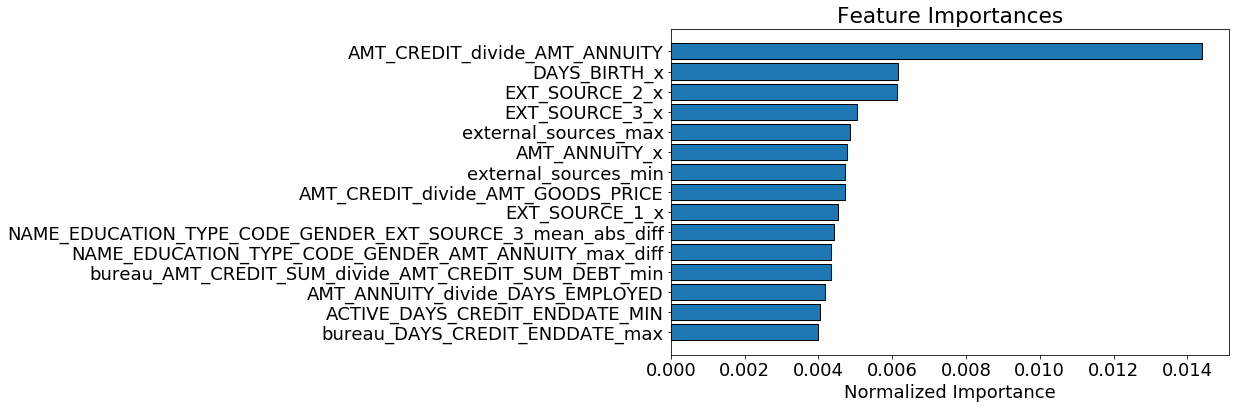

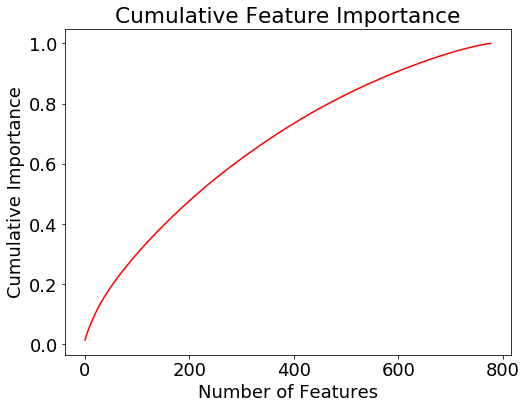

590 features required for 0.90 of cumulative importance


In [17]:
# feature_importances = pickle.load(open('../selection_comb_bo2_op5f4_simfe/fe_imp_corr_nan_df.pkl','rb'))
split_norm_fe_imp = plot_feature_importances(feature_importance_df)

In [18]:
# feature_importances = pickle.load(open('../selection_comb_bo2_op5f4_simfe/fe_imp_corr_nan_df.pkl','rb'))
split_norm_fe_imp = plot_feature_importances(split_imp)

NameError: name 'split_imp' is not defined